In [ ]:

!pip install nltk


In [ ]:
import numpy as np
import pandas as pd
import nltk
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
url = 'https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/refs/heads/master/data/labeled_data.csv'
data = pd.read_csv(url)


In [ ]:
data.head()
data.info()
data['class'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


,count
class,
1,19190
2,4163
0,1430


In [ ]:
texts = data['tweet']
labels = data['class'].apply(lambda x: 1 if x != 0 else 0)


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(texts)

X = tokenizer.texts_to_sequences(texts)
X = pad_sequences(X, maxlen=100)
labels = data['class'].apply(lambda x: 1 if x != 0 else 0)

y = np.array(labels)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
from tensorflow.keras.optimizers import Adam
import pandas as pd

embedding_dims = [50, 100]
ffnn_units_list = [64, 128]

results = []

vocab_size = 5000  
sentence_length = X_train.shape[1]

for embed_dim in embedding_dims:
    for ffnn_units in ffnn_units_list:
        print(f"\nTraining FFNN with Embedding Dim: {embed_dim}, FFNN Units: {ffnn_units}")

        model = Sequential([
            Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=sentence_length),
            Flatten(),
            Dense(ffnn_units, activation='relu'),
            Dense(1, activation='sigmoid')
        ])

        model.compile(optimizer=Adam(learning_rate=0.001),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

        model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.1, verbose=0)
        loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

        results.append({
            "Embedding Dim": embed_dim,
            "FFNN Units": ffnn_units,
            "Accuracy (%)": round(accuracy * 100, 2),
            "Loss": round(loss, 4)
        })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))



Training FFNN with Embedding Dim: 50, FFNN Units: 64


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Training FFNN with Embedding Dim: 50, FFNN Units: 128

Training FFNN with Embedding Dim: 100, FFNN Units: 64

Training FFNN with Embedding Dim: 100, FFNN Units: 128
 Embedding Dim  FFNN Units  Accuracy (%)   Loss
            50          64         93.38 0.3512
            50         128         93.10 0.3811
           100          64         93.69 0.4140
           100         128         92.82 0.3807


In [ ]:
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text)
    text = re.sub(r'\d+', '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

texts = texts.apply(preprocess)


In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(texts).toarray()
y = labels.values


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.1)


Epoch 1/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 30s 50ms/step - accuracy: 0.9309 - loss: 0.2481 - val_accuracy: 0.9491 - val_loss: 0.1811
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.9511 - loss: 0.1260 - val_accuracy: 0.9440 - val_loss: 0.1959
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - accuracy: 0.9627 - loss: 0.0930 - val_accuracy: 0.9390 - val_loss: 0.2299
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - accuracy: 0.9789 - loss: 0.0554 - val_accuracy: 0.9324 - val_loss: 0.2990
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 24s 41ms/step - accuracy: 0.9904 - loss: 0.0251 - val_accuracy: 0.9385 - val_loss: 0.3532
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 24s 43ms/step - accuracy: 0.9954 - loss: 0.0145 - val_accuracy: 0.9420 - val_loss: 0.4478
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 36s 33ms/step - accuracy: 0.9962 - loss: 0.0112 - val_accuracy: 0.9410 - val_loss: 0.4890
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.9968 - loss: 0.0110 - 

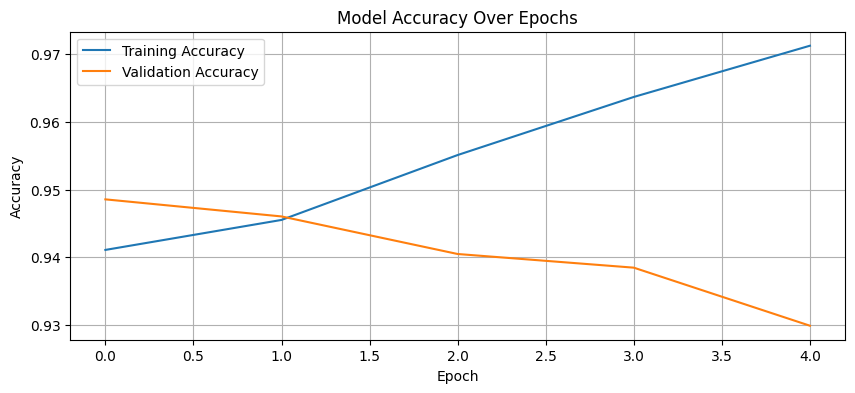

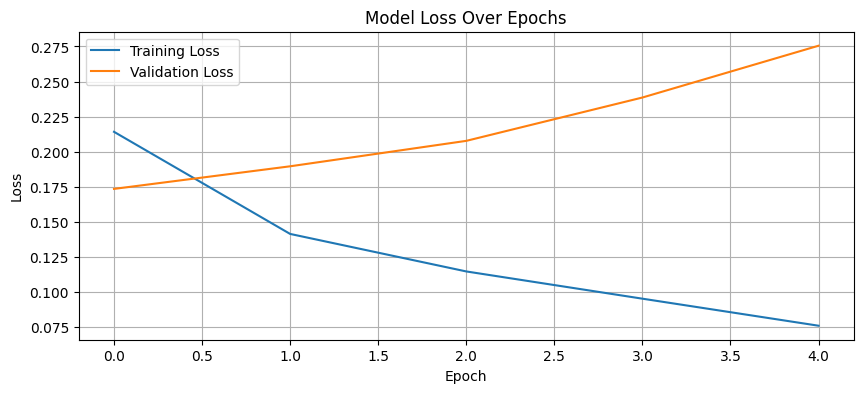

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def build_model(layer1_units=512, layer2_units=256, dropout_rate=0.3, learning_rate=0.001):
    model = Sequential([
        Dense(layer1_units, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(dropout_rate),
        Dense(layer2_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:
configs = [
    {"layer1_units": 512, "layer2_units": 256, "dropout_rate": 0.3, "learning_rate": 0.001},
    {"layer1_units": 256, "layer2_units": 128, "dropout_rate": 0.2, "learning_rate": 0.0005},
    {"layer1_units": 128, "layer2_units": 64,  "dropout_rate": 0.4, "learning_rate": 0.001},
]

results = []

for config in configs:
    print(f"\nTesting Config: {config}")
    model = build_model(**config)
    history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.1, verbose=0)
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    results.append((config, loss, accuracy))
    print(f"Loss: {loss:.4f}, Accuracy: {accuracy*100:.2f}%")



Testing Config: {'layer1_units': 512, 'layer2_units': 256, 'dropout_rate': 0.3, 'learning_rate': 0.001}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Loss: 0.3735, Accuracy: 93.71%

Testing Config: {'layer1_units': 256, 'layer2_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.0005}
Loss: 0.3184, Accuracy: 93.18%

Testing Config: {'layer1_units': 128, 'layer2_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.001}
Loss: 0.2662, Accuracy: 93.12%


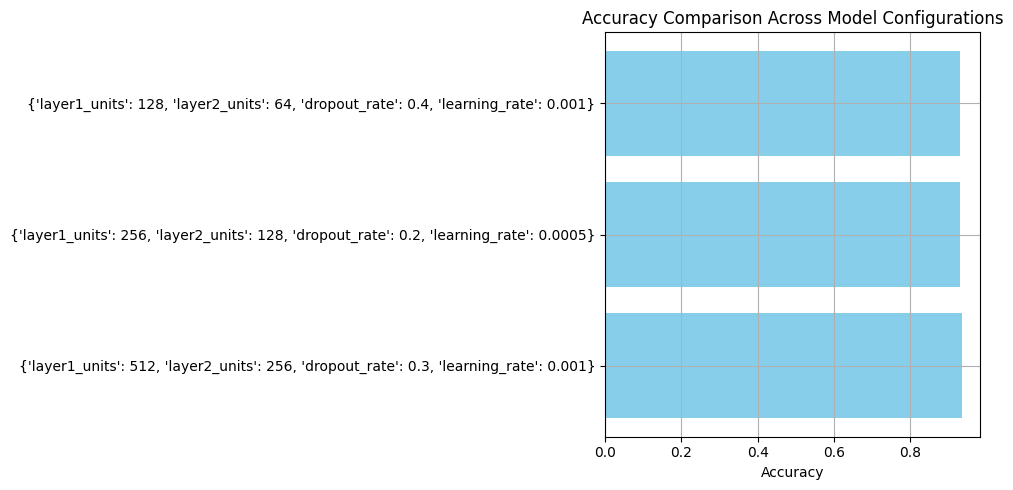

In [ ]:
import matplotlib.pyplot as plt

labels = [str(cfg) for cfg, _, _ in results]
accuracies = [acc for _, _, acc in results]

plt.figure(figsize=(10, 5))
plt.barh(labels, accuracies, color='skyblue')
plt.xlabel("Accuracy")
plt.title("Accuracy Comparison Across Model Configurations")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = (model.predict(X_test) > 0.5).astype("int32").flatten()
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Hate", "Not Hate"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")


155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9356 - loss: 0.5805
Test Loss: 0.5449
Test Accuracy: 93.73%


In [ ]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
              precision    recall  f1-score   support

           0       0.41      0.16      0.22       290
           1       0.95      0.99      0.97      4667

    accuracy                           0.94      4957
   macro avg       0.68      0.57      0.60      4957
weighted avg       0.92      0.94      0.92      4957

[[  45  245]
 [  66 4601]]


155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
AUC Score: 0.7568


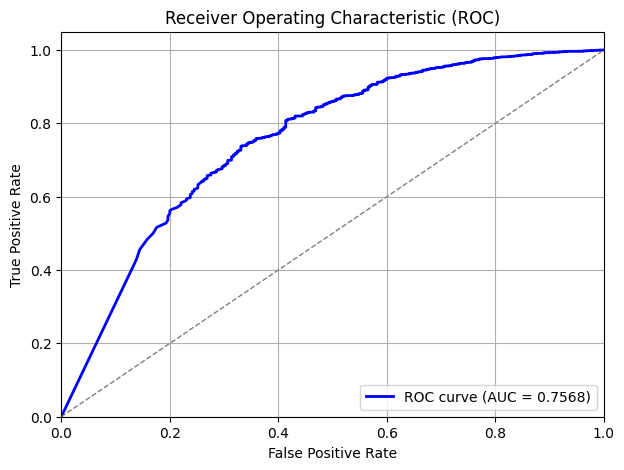

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_prob = model.predict(X_test).ravel()

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

roc_auc = auc(fpr, tpr)
print(f"AUC Score: {roc_auc:.4f}")

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid()
plt.show()


155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


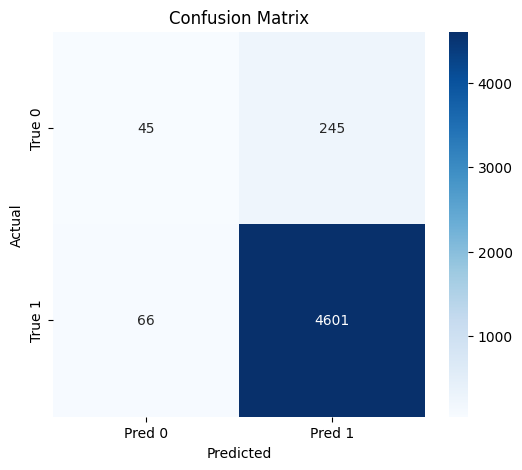

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

y_prob = model.predict(X_test).ravel()
y_pred = (y_prob >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
